In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import math

import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from pymongo import MongoClient
import json

In [2]:
con = MongoClient('localhost',27017)
db = con.politica

In [3]:
dataset = pd.DataFrame()

In [4]:
list_tweets = list(db.tweets_marina.find())
text_tweets = []
for tweet in list_tweets[0:math.floor(len(list_tweets)*0.5)]:
    twitterText = ""
    if('retweeted_status' in tweet):
        if('extended_tweet' in tweet['retweeted_status']):
            twitterText = tweet['retweeted_status']['extended_tweet']['full_text']
        else:
            twitterText = tweet['retweeted_status']['text']

    elif('extended_tweet' in tweet):
        twitterText = tweet['extended_tweet']['full_text']
    else:
        twitterText = tweet['text']
    
    text_tweets.append(twitterText)

dataset['text'] = pd.Series(text_tweets)

In [5]:
dataset['text_processed'] = np.nan

In [6]:
stemmer = nltk.stem.RSLPStemmer()
for ind, tweet in enumerate(dataset['text']):
    t = tweet
    t = t.lower() # removendo letras maiúsculas
    t = re.sub(r'(\b)?@\w+','',t) #removendo referências a outros perfis
    t = re.sub(r'(\b)?#\w+','',t) #removendo hashtags
    t = re.sub(r'http\S+','',t,flags=re.MULTILINE) #removendo links
    t = re.sub(r'https\S+','',t,flags=re.MULTILINE) #removendo links
    t = re.sub(r'(\w+)?\d(\w+)?','',t) # removendo números
    t = re.sub(r',|\"|!|\n|:|\.|\?|;|\(|\)|#',' ',t) #removendo pontuações
    
    # removendo stopwords
    nsw = ''
    for word in t.split(' '):
        if word not in stopwords.words('portuguese'):
            nsw += word+' '
    t = nsw.strip()
    t = re.sub(r' +',' ',t) # removendo espaços duplos
    t = t.strip() # remover espaços vazios no início e no fim
    
    # isolando o radical das palavras
    if len(t) > 0:
        t = t.split(' ')
        ste = [stemmer.stem(word) for word in t]
        processedTweet = ' '.join(ste)
        dataset['text_processed'][ind] = processedTweet
    else:
        dataset['text_processed'][ind] = ''

/home/alysson/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/alysson/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
dataset.head()

,text,text_processed
0,OPORTUNISTA QUE APARECE DE 4 EM 4 ANOS !!!\nRe...,oportun aparec ano red lanç pré-candidat marin...
1,"Sendo mesmo um assassinato, lembro a vocês que...",send assassinat lembr sabot mat marin silv poi...
2,"Hahaha, o famoso tiro que vai sair pela culatr...",hahah fam tir vai sair culatr
3,@Ciro2018 @DanielDcmjr Ciro Gomes é oportunist...,cir gom é oportun tal marin silv dic cir p pre...
4,Resultado do STF reafirmou que todos são iguai...,result stf reafirm tod igual per lei diz marin...


In [8]:
count_vect = CountVectorizer()
matrix_vectorized = count_vect.fit_transform(dataset['text_processed'].values.tolist())
print(matrix_vectorized.shape)
print(count_vect.get_feature_names()[0:10])

(9290, 5821)
['aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaa', 'aaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'aaaaah', 'aahahahahahahahahhahaahahahahahahahahhah', 'aba', 'abaix']


# Clustering with DBScan

In [9]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import DBSCAN

In [10]:
matrix_distances_euclidean = euclidean_distances(matrix_vectorized)
matrix_distances_euclidean.shape

(9290, 9290)

In [11]:
print("Distância euclidiana, máximo: ",matrix_distances_euclidean.max())
print("Distância euclidiana, média: ",matrix_distances_euclidean.mean())
print("Distância euclidiana, std: ",matrix_distances_euclidean.std())
print("Distância euclidiana, mínimo: ",matrix_distances_euclidean.std())

Distância euclidiana, máximo:  34.07345007480164
Distância euclidiana, média:  4.557548683594037
Distância euclidiana, std:  1.5112828277591817
Distância euclidiana, mínimo:  1.5112828277591817


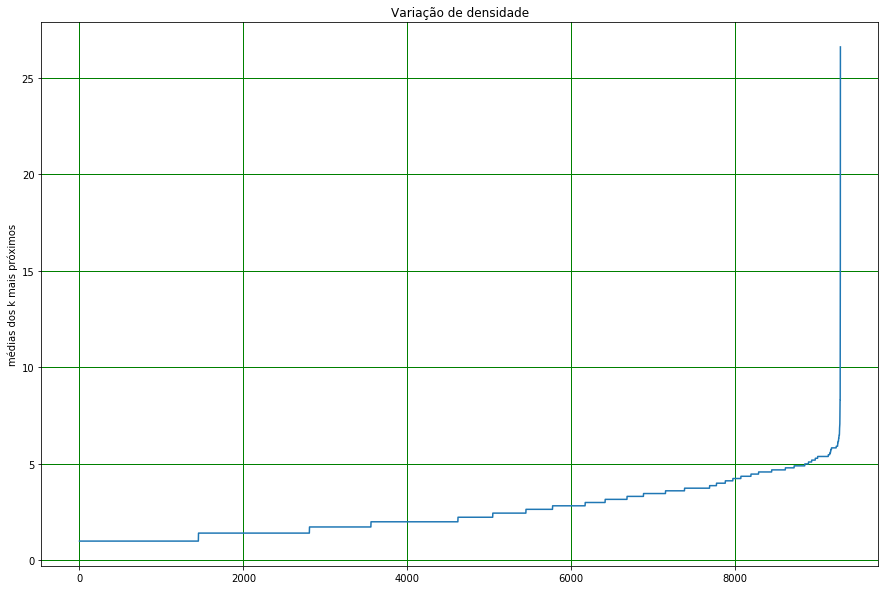

In [12]:
def k_dist(k, i, points):
    dist = []
    smaller = np.max(points)
    for i in range(0,k):
        for j in range(len(points)):
            if j != i:
                if points[j] < smaller and points[j] != 0:
                    smaller = points[j]
        dist.append(smaller)
    return np.mean(dist)

i = 0
y = []
while i < len(matrix_distances_euclidean):
    y.append(k_dist(3,i,matrix_distances_euclidean[i]))
    i += 1
y.sort()
    
plt.figure(figsize=(15,10))
plt.plot(y)
plt.grid(color='g', linestyle='-', linewidth=1)
plt.ylabel('médias dos k mais próximos')
plt.title('Variação de densidade')
plt.show()

In [12]:
minPoints = math.log(len(matrix_distances_euclidean))
dbscan_euclidean_distance = DBSCAN(eps=matrix_distances_euclidean.mean()+(matrix_distances_euclidean.std()/2), min_samples= 2*minPoints, metric="precomputed")
clusters_euclidean_dbscan = dbscan_euclidean_distance.fit(matrix_distances_euclidean)
dataset['cluster_euclidean_dbscan'] = clusters_euclidean_dbscan.labels_

### Grid Search for *eps* and *minPoints*

# Clustering with Kmeans

In [13]:
# from sklearn.metrics.pairwise import euclidean_distances
# from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

In [14]:
# kmeans_euclidean_distance = KMeans(n_clusters=3, precompute_distances=True)
kmeans_euclidean_distance = MiniBatchKMeans(n_clusters=3)
# clusters_euclidean_kmeans = kmeans_euclidean_distance.fit(matrix_distances_euclidean)
clusters_euclidean_kmeans = kmeans_euclidean_distance.fit(matrix_vectorized)
dataset['cluster_euclidean_kmeans'] = clusters_euclidean_kmeans.labels_

In [15]:
dataset.head()

,text,text_processed,cluster_euclidean_dbscan,cluster_euclidean_kmeans
0,OPORTUNISTA QUE APARECE DE 4 EM 4 ANOS !!!\nRe...,oportun aparec ano red lanç pré-candidat marin...,0,2
1,"Sendo mesmo um assassinato, lembro a vocês que...",send assassinat lembr sabot mat marin silv poi...,0,2
2,"Hahaha, o famoso tiro que vai sair pela culatr...",hahah fam tir vai sair culatr,0,0
3,@Ciro2018 @DanielDcmjr Ciro Gomes é oportunist...,cir gom é oportun tal marin silv dic cir p pre...,0,2
4,Resultado do STF reafirmou que todos são iguai...,result stf reafirm tod igual per lei diz marin...,0,2


# Clusters

In [16]:
dataset['cluster_euclidean_dbscan'].value_counts()

 0    9007
-1     136
 2      69
 3      52
 1      26
Name: cluster_euclidean_dbscan, dtype: int64

In [17]:
dataset['cluster_euclidean_kmeans'].value_counts()

2    5121
0    4100
1      69
Name: cluster_euclidean_kmeans, dtype: int64

* ### Evaluation

In [18]:
#Sum-of-Squared-Error
kmeans_euclidean_distance.inertia_

99899.32306293746

In [19]:
#Silhouette Value
from sklearn.metrics import silhouette_score

silhouette_score(X=matrix_distances_euclidean,labels=kmeans_euclidean_distance.labels_)

-0.04010792666498891

In [20]:
silhouette_score(X=matrix_distances_euclidean,labels=dbscan_euclidean_distance.labels_)

0.3334403817178547

* ### Polarity of the tweets

In [21]:
from Polarity import Polarity

In [22]:
Polarity.load()
Polarity.base_lexica.head()

,palavra,gn,tg,pol,anot,pos
0,"abafadas,abafado",GN=fp,TG=HUM,POL=-1,ANOT=JALC,PoS=Adj
1,"abafado,abafado",GN=ms,TG=HUM,POL=-1,ANOT=JALC,PoS=Adj
2,"abafados,abafado",GN=mp,TG=HUM,POL=-1,ANOT=JALC,PoS=Adj
3,"abafante,abafante",GN=fs,TG=HUM,POL=-1,ANOT=MAN,PoS=Adj
4,"abafante,abafante",GN=ms,TG=HUM,POL=-1,ANOT=MAN,PoS=Adj


In [23]:
dataset['polaridade'] = 0

j = 0
for tweet in dataset.text:
    twt = Polarity.preProcessor(tweet)
    score = 0
    for p in twt.split(' '):
        score += Polarity.searchWord(p)
    dataset.polaridade[j] = score
    j += 1

/home/alysson/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [24]:
dataset.head()

,text,text_processed,cluster_euclidean_dbscan,cluster_euclidean_kmeans,polaridade
0,OPORTUNISTA QUE APARECE DE 4 EM 4 ANOS !!!\nRe...,oportun aparec ano red lanç pré-candidat marin...,0,2,-2
1,"Sendo mesmo um assassinato, lembro a vocês que...",send assassinat lembr sabot mat marin silv poi...,0,2,-1
2,"Hahaha, o famoso tiro que vai sair pela culatr...",hahah fam tir vai sair culatr,0,0,-2
3,@Ciro2018 @DanielDcmjr Ciro Gomes é oportunist...,cir gom é oportun tal marin silv dic cir p pre...,0,2,-4
4,Resultado do STF reafirmou que todos são iguai...,result stf reafirm tod igual per lei diz marin...,0,2,-1


* ### Analyzes

In [25]:
dataset.groupby('cluster_euclidean_dbscan')['polaridade'].sum()

cluster_euclidean_dbscan
-1    -518
 0   -9746
 1      26
 2     -69
 3     -52
Name: polaridade, dtype: int64

In [26]:
dataset.groupby('cluster_euclidean_dbscan')['polaridade'].mean()

cluster_euclidean_dbscan
-1   -3.808824
 0   -1.082047
 1    1.000000
 2   -1.000000
 3   -1.000000
Name: polaridade, dtype: float64

In [27]:
dbscan_pos,dbscan_neg,dbscan_neu = 0,0,0
clusters_dbscan = []
for i in range(-1,len(dataset.groupby('cluster_euclidean_dbscan'))-1):
    dbscan_pos,dbscan_neg,dbscan_neu = 0,0,0
    for v in dataset.polaridade[dataset.cluster_euclidean_dbscan[dataset.cluster_euclidean_dbscan == i].index].values:
        if v < 0:
            dbscan_neg += 1
        if v > 0:
            dbscan_pos += 1
        if v == 0:
            dbscan_neu += 1
    print('Cluster '+str(i))
    print('pos = ',str(dbscan_pos), '; neg = ',str(dbscan_neg), '; neu=',str(dbscan_neu))
    clusters_dbscan.append((dbscan_pos,dbscan_neg,dbscan_neu))

Cluster -1
pos =  18 ; neg =  109 ; neu= 9
Cluster 0
pos =  1370 ; neg =  4871 ; neu= 2766
Cluster 1
pos =  26 ; neg =  0 ; neu= 0
Cluster 2
pos =  0 ; neg =  69 ; neu= 0
Cluster 3
pos =  0 ; neg =  52 ; neu= 0


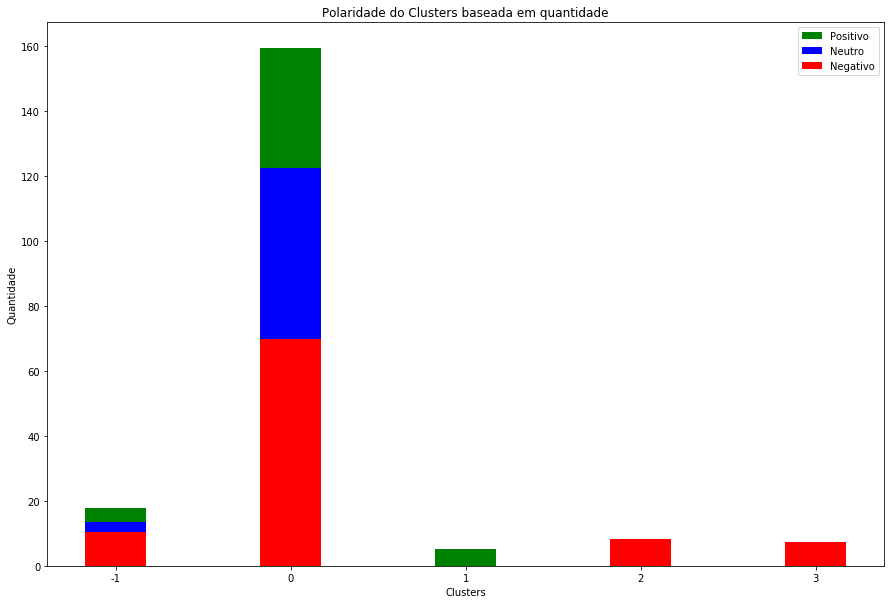

In [28]:
def normalize(t, i):
    return math.sqrt(t[i])

def labelCluster(i):
    return str(i)

# Gráfico de distribuição de polaridades

C = len(dataset.groupby('cluster_euclidean_dbscan'))
dbscan_pos = np.array([normalize(i,0) for i in clusters_dbscan])
dbscan_neg = np.array([normalize(i,1) for i in clusters_dbscan])
dbscan_neu = np.array([normalize(i,2) for i in clusters_dbscan])

ind = np.arange(C)
width = 0.35

plt.figure(figsize=(15,10))
pNeg = plt.bar(ind, dbscan_neg, width, color='r')
pNeu = plt.bar(ind, dbscan_neu, width, bottom=dbscan_neg, color='b')
pPos = plt.bar(ind, dbscan_pos, width, bottom=dbscan_neu+dbscan_neg, color='g')


plt.ylabel('Quantidade')
plt.xlabel('Clusters')
plt.title('Polaridade do Clusters baseada em quantidade')
plt.xticks(ind, tuple([labelCluster(i) for i in range(-1,C+1)]))
plt.legend((pPos[0], pNeu[0], pNeg[0]), ('Positivo', 'Neutro', 'Negativo'))

plt.show()

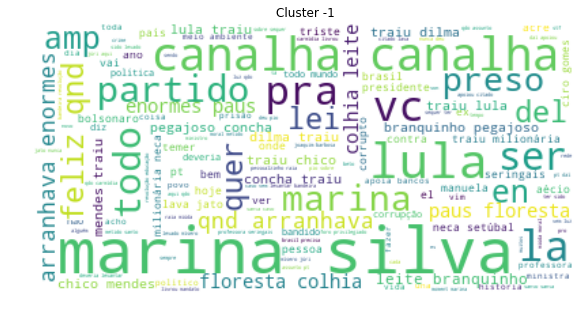

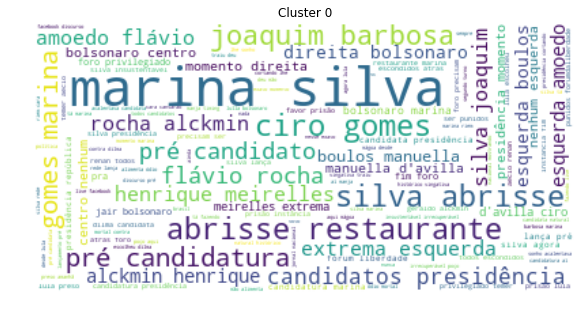

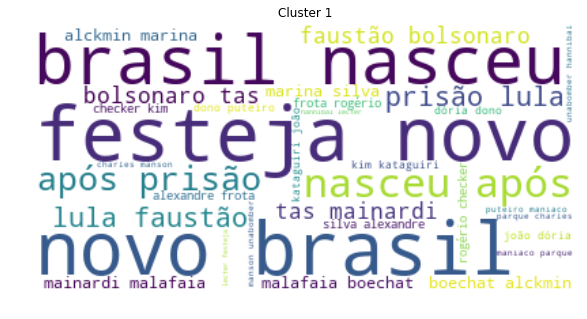

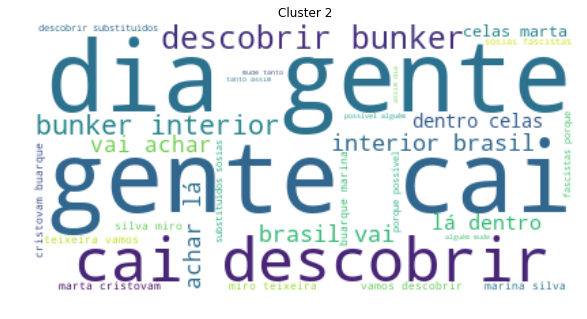

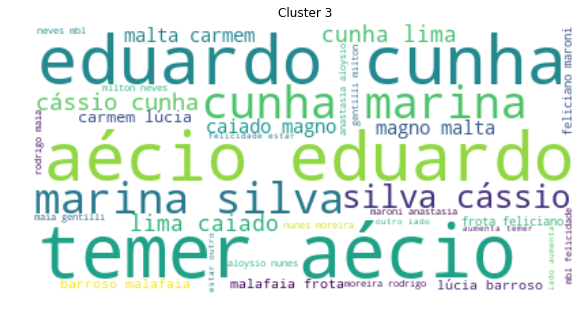

In [29]:
# Nuvem de palavras dos clustersfor i in count_clusters_dbscan:
from wordcloud import WordCloud

count_clusters_dbscan = dataset.cluster_euclidean_dbscan.value_counts().index.tolist()
count_clusters_dbscan.sort()

for i in count_clusters_dbscan:
    text = Polarity.preProcessor(" ".join(dataset.text[dataset.cluster_euclidean_dbscan == i].tolist()))
    
    wordcloud = WordCloud(background_color='white', max_words=2500).generate(text)

    plt.figure(figsize=(10,5))
    plt.title('Cluster '+str(i))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

plt.show()

In [30]:
dataset.groupby('cluster_euclidean_kmeans')['polaridade'].sum()

cluster_euclidean_kmeans
0   -4113
1     -69
2   -6177
Name: polaridade, dtype: int64

In [31]:
dataset.groupby('cluster_euclidean_kmeans')['polaridade'].mean()

cluster_euclidean_kmeans
0   -1.003171
1   -1.000000
2   -1.206210
Name: polaridade, dtype: float64

In [32]:
kmeans_pos,kmeans_neg,kmeans_neu = 0,0,0
clusters_kmeans = []
for i in range(0,3):
    kmeans_pos,kmeans_neg,kmeans_neu = 0,0,0
    for v in dataset.polaridade[dataset.cluster_euclidean_kmeans[dataset.cluster_euclidean_kmeans == i].index].values:
        if v < 0:
            kmeans_neg += 1
        if v > 0:
            kmeans_pos += 1
        if v == 0:
            kmeans_neu += 1
    print('Cluster '+str(i))
    print('pos = ',str(kmeans_pos), '; neg = ',str(kmeans_neg), '; neu=',str(kmeans_neu))
    clusters_kmeans.append((kmeans_pos,kmeans_neg,kmeans_neu))

Cluster 0
pos =  693 ; neg =  2365 ; neu= 1042
Cluster 1
pos =  0 ; neg =  69 ; neu= 0
Cluster 2
pos =  721 ; neg =  2667 ; neu= 1733


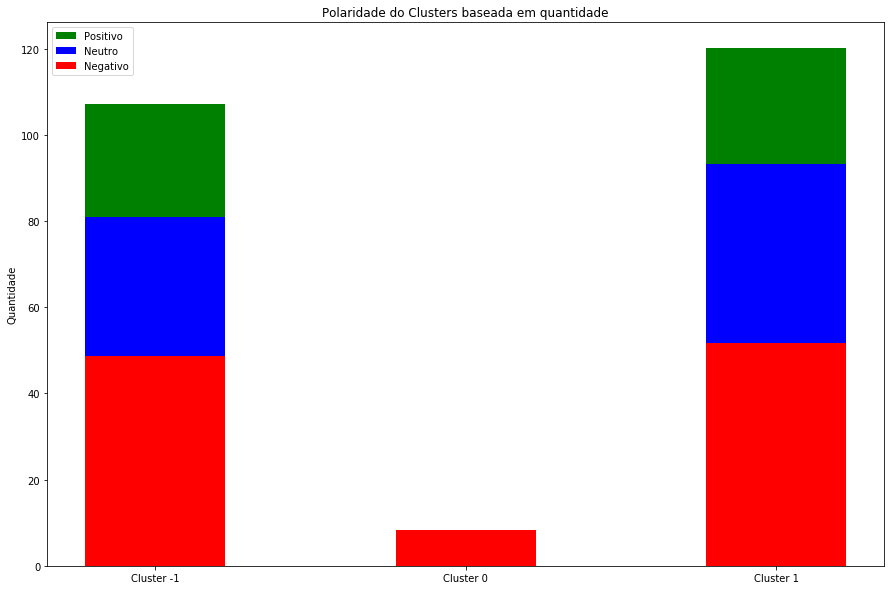

In [33]:
# Gráfico de distribuição de polaridades

C = 3
kmeans_pos = np.array([normalize(i,0) for i in clusters_kmeans])
kmeans_neg = np.array([normalize(i,1) for i in clusters_kmeans])
kmeans_neu = np.array([normalize(i,2) for i in clusters_kmeans])

ind = np.arange(C)
width = 0.45

plt.figure(figsize=(15,10))
pNeg = plt.bar(ind, kmeans_neg, width, color='r')
pNeu = plt.bar(ind, kmeans_neu, width, bottom=kmeans_neg, color='b')
pPos = plt.bar(ind, kmeans_pos, width, bottom=kmeans_neu+kmeans_neg, color='g')


plt.ylabel('Quantidade')
plt.title('Polaridade do Clusters baseada em quantidade')
plt.xticks(ind, ('Cluster -1', 'Cluster 0', 'Cluster 1', 'Cluster 2'))
plt.legend((pPos[0], pNeu[0], pNeg[0]), ('Positivo', 'Neutro', 'Negativo'))

plt.show()

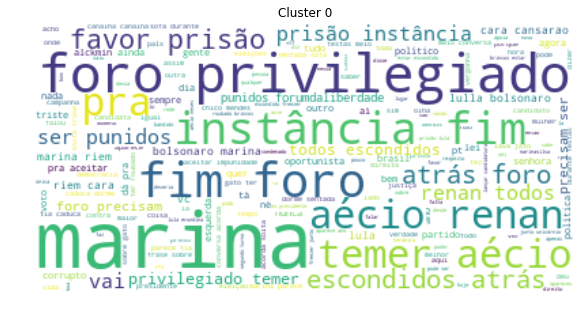

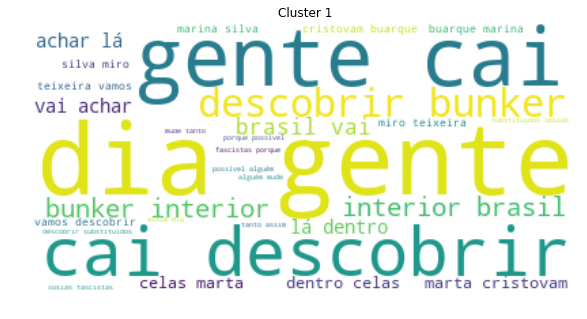

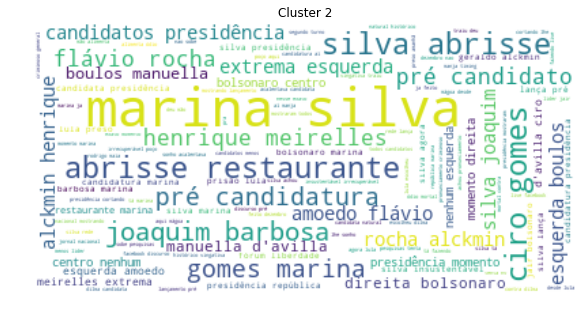

In [34]:
# Nuvem de palavras dos clusters
count_clusters_kmeans = dataset.cluster_euclidean_kmeans.value_counts().index.tolist()
count_clusters_kmeans.sort()

for i in count_clusters_kmeans:
    text = Polarity.preProcessor(" ".join(dataset.text[dataset.cluster_euclidean_kmeans == i].tolist()))
    
    wordcloud = WordCloud(background_color='white', max_words=2500).generate(text)

    plt.figure(figsize=(10,5))
    plt.title('Cluster '+str(i))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

plt.show()